### Dask SVD Benchmarks

These benchmarks look at compute times for tall-skinny/short-fat SVD and different sign correction methods.

In [1]:
import tqdm
import pandas as pd
import numpy as np
import plotnine as pn
import dask.array as da
from dask.array.linalg import tsqr

In [25]:
def svd_flip1(u, v):
    # Scikit-learn sign correction 
    # *uses sign of maximum value in eigenvector
    u, v = da.asarray(u), da.asarray(v)
    max_abs_cols = np.argmax(np.abs(u), axis=0)
    signs = np.sign(u.vindex[max_abs_cols, range(u.shape[1])])
    u *= signs
    v *= signs[:, np.newaxis]
    return u, v

def svd_flip2(u, v):
    # Correction using sign for vectors that puts them
    # in same half-space as an arbitrary vecotor (all ones)
    signs = np.dot(np.ones_like(u[:,0])[np.newaxis], u)
    signs = 2*((signs >= 0) - .5)
    u, v = u * signs, v * signs.T
    return u, v


def svd(a):
    nb = a.numblocks
    if a.ndim != 2:
        raise ValueError(
            "Array must be 2D.\n"
            "Input shape: {}\n"
            "Input ndim: {}\n".format(a.shape, a.ndim)
        )
    if nb[0] > 1 and nb[1] > 1:
        raise ValueError(
            "Array must be chunked in one dimension only. "
            "This function (svd) only supports tall-and-skinny or short-and-fat "
            "matrices (see da.linalg.svd_compressed for SVD on fully chunked arrays).\n"
            "Input shape: {}\n"
            "Input numblocks: {}\n".format(a.shape, nb)
        )

    # Tall-and-skinny case
    if nb[0] >= nb[1]:
        u, s, v = tsqr(a, compute_svd=True)
        return u, s, v
    # Short-and-fat case
    else:
        vt, s, ut = tsqr(a.T, compute_svd=True)
        return ut.T, s, vt.T
    

In [3]:
def run(x, svd_flip=None):
    m, n = x.shape
    k = min(m, n)
    u, s, v = svd(x)
    u, v = u[:, :k], v[:k, :]
    if svd_flip:
        u, v = svd_flip(u, v)
    # Ensure that aggregation is across same
    # number of elements regardless of transposition
    assert k**2 + k*max(m, n) == u.size + v.size
    return (u.mean() + v.mean()).compute()

def benchmark():
    df = []
    for arg in tqdm.tqdm([
        (s, t, fn)
        for s in 10**np.arange(2, 8)
        for t in [True, False]
        for fn in [None, svd_flip1, svd_flip2]
    ]):
        s, t, fn = arg
        if t:
            m, n, c = 100, s, (-1, 1000)
        else:
            m, n, c = s, 100, (1000, -1)
        x = da.random.random((m, n), chunks=c)
        f = fn.__name__ if fn else 'None'
        k = f'svd-shape={m:08d}x{n:08d}-t={t}-flip={f}'
        r = %timeit -n 1 -r 1 -o -q run(x, svd_flip=fn)
        df.append(dict(op=k, time=r.average, transpose=t, s=s, m=m, n=n))
    return pd.DataFrame(df)

In [4]:
%%time
df = benchmark()

100%|██████████| 36/36 [23:31<00:00, 39.20s/it] 

CPU times: user 31min 50s, sys: 2min 19s, total: 34min 9s
Wall time: 23min 31s


In [5]:
df

,op,time,transpose,s,m,n
0,svd-shape=00000100x00000100-t=True-flip=None,0.035216,True,100,100,100
1,svd-shape=00000100x00000100-t=True-flip=svd_flip1,0.070028,True,100,100,100
2,svd-shape=00000100x00000100-t=True-flip=svd_flip2,0.045620,True,100,100,100
3,svd-shape=00000100x00000100-t=False-flip=None,0.026825,False,100,100,100
4,svd-shape=00000100x00000100-t=False-flip=svd_f...,0.057928,False,100,100,100
5,svd-shape=00000100x00000100-t=False-flip=svd_f...,0.048828,False,100,100,100
6,svd-shape=00000100x00001000-t=True-flip=None,0.155585,True,1000,100,1000
7,svd-shape=00000100x00001000-t=True-flip=svd_flip1,0.195429,True,1000,100,1000
8,svd-shape=00000100x00001000-t=True-flip=svd_flip2,0.143165,True,1000,100,1000
9,svd-shape=00001000x00000100-t=False-flip=None,0.026245,False,1000,1000,100


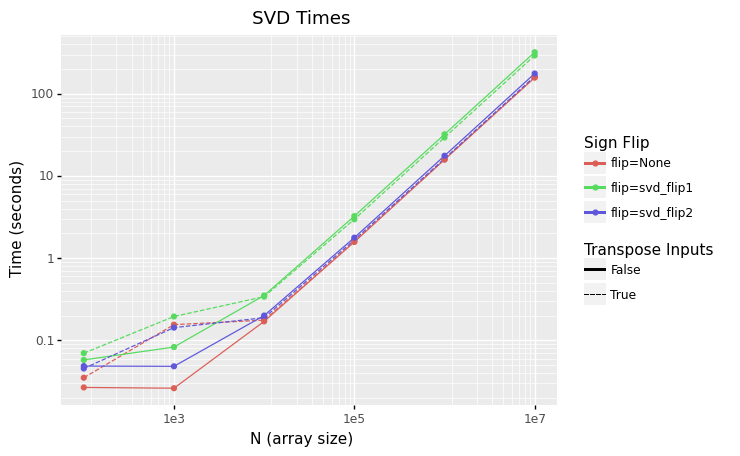

<ggplot: (8734030158685)>

In [6]:
pdf = df.assign(flip=lambda df: df.op.str.extract('(flip=.*)'))
(
    pn.ggplot(
        pdf,
        pn.aes(x='s', y='time', color='flip', linetype='transpose')
    ) +
    pn.geom_line() + 
    pn.geom_point() +
    pn.scale_x_log10() + 
    pn.scale_y_log10() + 
    pn.labs(
        x='N (array size)', y='Time (seconds)', title='SVD Times', 
        color='Sign Flip', linetype='Transpose Inputs'
    )
)

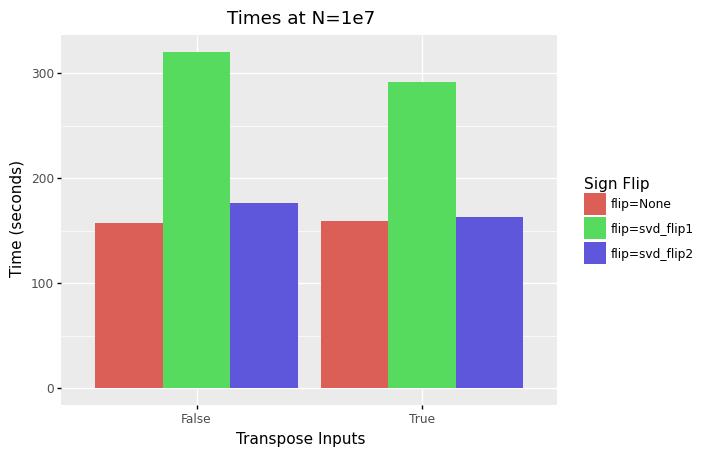

<ggplot: (8733971587229)>

In [7]:
pdf = df.assign(flip=lambda df: df.op.str.extract('(flip=.*)'))
(
    pn.ggplot(
        pdf[pdf['s'] == 1e7],
        pn.aes(x='transpose', y='time', fill='flip')
    ) +
    pn.geom_bar(stat='identity', position='dodge') + 
    pn.labs(x='Transpose Inputs', y='Time (seconds)', title='Times at N=1e7', fill='Sign Flip')
)